In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from scipy.optimize import curve_fit

Using TensorFlow backend.
C:\Users\Hana Flores\PythonStuff\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hana Flores\PythonStuff\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hana Flores\PythonStuff\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hana Flores\PythonStuff\lib\site-packages\tenso

In [2]:
# Read csv of Education distribution
# Remove all the entries that don't have "County"
df = pd.read_csv('Education_data_compiled.csv')
df = df[df['Area name'].str.contains('County')]
df = df.sort_values(by=['State','Area name'],ignore_index=True)

In [3]:
# Add columns of Unemployment and Median HH Income
new_df = pd.read_csv('Unemployed_data_compiled.csv')
new_df = new_df[new_df['Area name'].str.contains('County')]
new_df.sort_values(by=['Area name'],ignore_index=True)

# For this file, area name stick with state => split it
def f(x,delm=','):
    return x.split(delm)[0], x.split(delm)[1][1:]

new_df['State'] = new_df['Area name'].map(lambda x: f(x)[1])
new_df['Area name'] = new_df['Area name'].map(lambda x: f(x)[0])

new_df = new_df.sort_values(by=['State','Area name'],ignore_index=True)
result = pd.merge(df,new_df,how='inner', on=['Area name','State'])
df = result.rename(columns={"Area name": "County", "Unemployment_rate_2019": "Percent of unemployment 2019", 
                       "Median_Household_Income_2018": "Median Household Income 2018"})
result

,State,Area name,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Unemployment_rate_2019,Median_Household_Income_2018
0,AL,Autauga County,11.3,32.6,28.4,27.7,2.7,"59,338"
1,AL,Baldwin County,9.7,27.6,31.3,31.3,2.7,"57,588"
2,AL,Barbour County,27.0,35.7,25.1,12.2,3.8,"34,382"
3,AL,Bibb County,16.8,47.3,24.4,11.5,3.1,"46,064"
4,AL,Blount County,19.8,34.0,33.5,12.6,2.7,"50,412"
...,...,...,...,...,...,...,...,...
2994,WY,Sweetwater County,9.0,33.3,35.7,22.0,3.9,"73,315"
2995,WY,Teton County,5.6,13.2,23.8,57.4,2.7,"99,087"
2996,WY,Uinta County,7.2,40.1,37.2,15.4,3.9,"63,401"
2997,WY,Washakie County,10.4,30.3,37.7,21.5,3.9,"55,190"


In [4]:
# Add data of covid case
COVID_counties_df=pd.read_csv('us_counties_covid19_daily.csv')
del COVID_counties_df['fips']
COVID_baltimore_df=COVID_counties_df[COVID_counties_df['county']=='Baltimore']
print(COVID_baltimore_df)

             date     county     state  cases  deaths
1249    3/11/2020  Baltimore  Maryland      1       0
1467    3/12/2020  Baltimore  Maryland      1       0
1745    3/13/2020  Baltimore  Maryland      2       0
2085    3/14/2020  Baltimore  Maryland      3       0
2484    3/15/2020  Baltimore  Maryland      3       0
...           ...        ...       ...    ...     ...
558340  9/22/2020  Baltimore  Maryland  17546     619
561577  9/23/2020  Baltimore  Maryland  17603     621
564817  9/24/2020  Baltimore  Maryland  17678     621
568057  9/25/2020  Baltimore  Maryland  17743     622
571299  9/26/2020  Baltimore  Maryland  17805     622

[200 rows x 5 columns]


In [5]:
# Run the prediction
# univariate lstm example

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
# Perform prediction 
def single_pred(x_input, n_steps, n_features):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

In [7]:
def make_prediction(cases_train, n_steps, num_pred):
    yhat_array = np.zeros(num_pred)
    for i in range(num_pred):
        if i < len(cases_train)-n_steps:
            x_input = cases_train[i:i+n_steps]
            yhat = single_pred(x_input, n_steps, n_features)
            yhat_array[i] = yhat
        else:
            x_input = np.append(x_input[1:n_steps],yhat) # create feature from previous prediction
            yhat = single_pred(x_input, n_steps, n_features)
            yhat_array[i] = yhat
    return yhat_array

In [8]:
# Data:
cases = np.array(COVID_baltimore_df['cases'])
# Split data to train the model: 70:30
test_train_split = 0.7
cases_train = cases[0:int(len(cases)*test_train_split)]
cases_test = cases[int(len(cases)*test_train_split):]

In [9]:
# Perform prediction:

# choose a number of time steps (how many days to use for prediction)
n_steps = 3

# split into samples
X, y = split_sequence(cases_train, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

yhat_array = make_prediction(cases_train, n_steps, len(cases)-n_steps)
#print(yhat_array)

## Plotting the predicted cases vs. observed cases

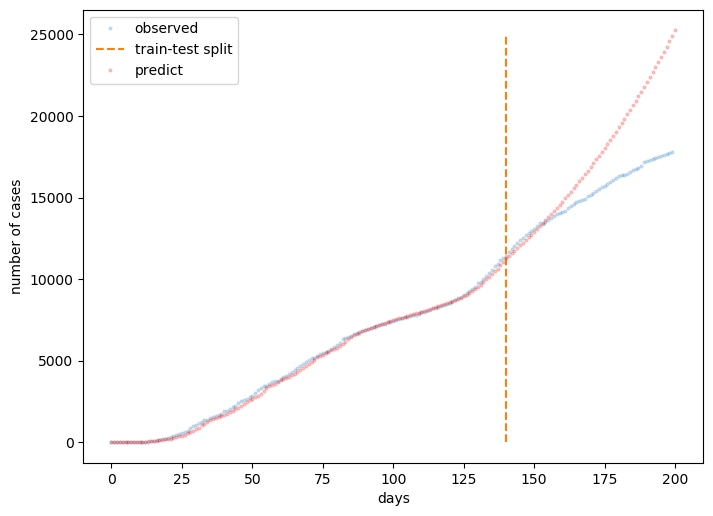

In [10]:
fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
#ax.plot(np.append(cases_train,yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.legend()

# Fitting the predicted cases to a polynomial regression model

y = 0.00005 * x^4 + -0.01415 * x^3 + 1.59912 * x^2 + 12.21355 * x + -363.37647


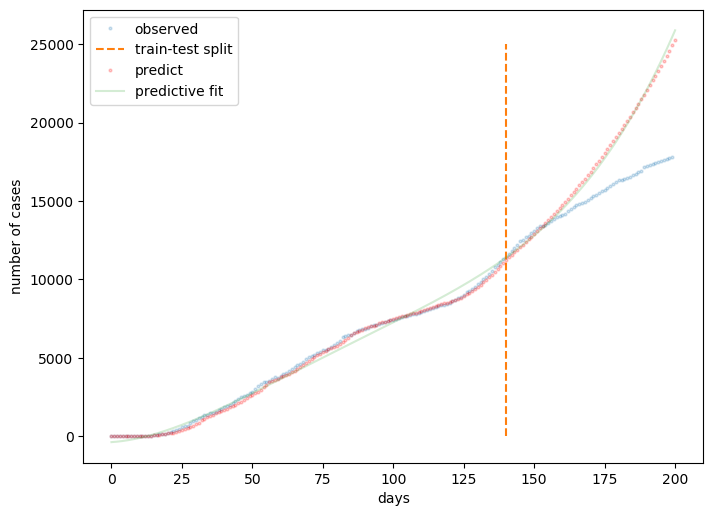

In [11]:
def get_fit_parameters(cases, yhat_array, n_steps):
    def objective(x, a, b, c, d, e):
        return a * x**4 + b * x**3 + c * x**2 + d * x + e
    y = np.append(cases[0:n_steps+1],yhat_array)
    num_of_values = len(y)
    x = np.linspace(0,num_of_values-1,num_of_values)
    popt, _ = curve_fit(objective, x, y)
    a, b, c, d, e = popt
    return a, b, c, d, e

a, b, c, d, e = get_fit_parameters(cases,yhat_array,n_steps)
print('y = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d, e))
y = np.append(cases[0:n_steps+1],yhat_array)
num_of_values = len(y)
x = np.linspace(0,num_of_values-1,num_of_values)
y_fit = a*x**4 + b*x**3 + c*x**2 + d*x + e

fig,ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(cases,'o',markersize=2,alpha=0.2,label='observed')
#ax.plot(np.append(cases_train,yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.plot([int(len(cases)*test_train_split),int(len(cases)*test_train_split)],[0,25000],'--',label='train-test split')
ax.plot(np.append(cases[0:n_steps+1],yhat_array),'or',markersize=2,alpha=0.2,label='predict')
ax.set_xlabel('days')
ax.set_ylabel('number of cases')
ax.plot(y_fit,markersize=2,alpha=0.2,label='predictive fit')
ax.legend()

## Single function to acquire regression parameters for a predicted covid function

In [12]:
def predict_case_fun_parameters(cases,n_steps,test_train_split):
    cases_train = cases[0:int(len(cases)*test_train_split)]
    cases_test = cases[int(len(cases)*test_train_split):]
    # Perform prediction:
    
    # split into samples
    X, y = split_sequence(cases_train, n_steps)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0)

    yhat_array = make_prediction(cases_train, n_steps, len(cases)-n_steps)
    #print(yhat_array)
    
    a, b, c, d, e = get_fit_parameters(cases,yhat_array,n_steps)
    
    return a,b,c,d,e,

In [13]:
a, b, c, d, e = predict_case_fun_parameters(cases,n_steps,test_train_split)
print('y = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d, e))

y = 0.00005 * x^4 + -0.01415 * x^3 + 1.59912 * x^2 + 12.21355 * x + -363.37647


## Dictionary to convert between state names and state abbreviations 

In [14]:
# United States of America Python Dictionary to translate States,
# Districts & Territories to Two-Letter codes and vice versa.
#
# https://gist.github.com/rogerallen/1583593
#
# Dedicated to the public domain.  To the extent possible under law,
# Roger Allen has waived all copyright and related or neighboring
# rights to this code.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))
# Simple test examples
if __name__ == '__main__':
    print("Wisconin --> WI?", us_state_abbrev['Wisconsin'] == 'WI')
    print("WI --> Wisconin?", abbrev_us_state['WI'] == 'Wisconsin')
    print("Number of entries (50 states, DC, 5 Territories) == 56? ", 56 == len(us_state_abbrev))

Wisconin --> WI? True
WI --> Wisconin? True
Number of entries (50 states, DC, 5 Territories) == 56?  True


In [15]:
result

,State,Area name,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Unemployment_rate_2019,Median_Household_Income_2018
0,AL,Autauga County,11.3,32.6,28.4,27.7,2.7,"59,338"
1,AL,Baldwin County,9.7,27.6,31.3,31.3,2.7,"57,588"
2,AL,Barbour County,27.0,35.7,25.1,12.2,3.8,"34,382"
3,AL,Bibb County,16.8,47.3,24.4,11.5,3.1,"46,064"
4,AL,Blount County,19.8,34.0,33.5,12.6,2.7,"50,412"
...,...,...,...,...,...,...,...,...
2994,WY,Sweetwater County,9.0,33.3,35.7,22.0,3.9,"73,315"
2995,WY,Teton County,5.6,13.2,23.8,57.4,2.7,"99,087"
2996,WY,Uinta County,7.2,40.1,37.2,15.4,3.9,"63,401"
2997,WY,Washakie County,10.4,30.3,37.7,21.5,3.9,"55,190"


In [16]:
result['State']
len(result['State'])
for i in range(len(result['State'])):
    result['State'][i]=abbrev_us_state[result['State'][i]]
result
COVID_counties_df

C:\Users\Hana Flores\PythonStuff\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,county,state,cases,deaths
0,1/21/2020,Snohomish,Washington,1,0
1,1/22/2020,Snohomish,Washington,1,0
2,1/23/2020,Snohomish,Washington,1,0
3,1/24/2020,Cook,Illinois,1,0
4,1/24/2020,Snohomish,Washington,1,0
...,...,...,...,...,...
573333,9/26/2020,Sweetwater,Wyoming,332,2
573334,9/26/2020,Teton,Wyoming,536,1
573335,9/26/2020,Uinta,Wyoming,350,2
573336,9/26/2020,Washakie,Wyoming,113,6


In [17]:
for i in range(len(result['Area name'])):
    result['Area name'][i]=result['Area name'][i].replace(' County', '')

C:\Users\Hana Flores\PythonStuff\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
state_names=result.State.unique()
cases_matrix=[]
for i in range(len(state_names)):
    state_covid=COVID_counties_df[COVID_counties_df['state']==state_names[i]]
    counties_in_state=result[result['State']==state_names[i]]['Area name'].unique()
    for j in range(len(counties_in_state)):
        county_covid=state_covid[state_covid['county']==counties_in_state[j]]
        cases_matrix+=[np.array(county_covid['cases'])]

In [19]:
cases_matrix[0]

array([   1,    4,    6,    6,    6,    6,    7,    7,   10,   10,   12,
         12,   12,   12,   12,   12,   17,   17,   19,   19,   19,   23,
         25,   25,   26,   25,   27,   28,   30,   32,   33,   36,   37,
         37,   39,   40,   43,   42,   42,   45,   48,   53,   53,   58,
         61,   67,   68,   74,   84,   91,   93,  104,  103,  110,  110,
        120,  127,  136,  147,  149,  155,  159,  168,  189,  192,  205,
        212,  216,  221,  234,  240,  240,  242,  249,  260,  266,  273,
        283,  296,  316,  327,  335,  361,  368,  373,  375,  400,  411,
        431,  434,  442,  453,  469,  479,  488,  498,  503,  527,  537,
        553,  561,  568,  591,  615,  618,  644,  651,  661,  670,  684,
        706,  728,  746,  756,  780,  789,  827,  842,  857,  865,  886,
        905,  921,  932,  942,  965,  974,  987, 1002, 1015, 1030, 1052,
       1066, 1073, 1073, 1096, 1113, 1134, 1217, 1222, 1215, 1241, 1250,
       1252, 1262, 1273, 1274, 1291, 1298, 1298, 13

In [20]:
a_column=[]
b_column=[]
c_column=[]
d_column=[]
e_column=[]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

for cases in cases_matrix:
    n_steps=3
    if len(cases)<n_steps+1:
        a_column+=[0]
        b_column+=[0]
        c_column+=[0]
        d_column+=[0]
        e_column+=[0]
    else:    
        cases_train = cases[0:int(len(cases)*test_train_split)]
        cases_test = cases[int(len(cases)*test_train_split):]
        # Perform prediction:

        # split into samples
        X, y = split_sequence(cases_train, n_steps)
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))

        # fit model
        model.fit(X, y, epochs=200, verbose=0)

        yhat_array = make_prediction(cases_train, n_steps, len(cases)-n_steps)
        #print(yhat_array)

        a, b, c, d, e = get_fit_parameters(cases,yhat_array,n_steps)
        a_column+=[a]
        b_column+=[b]
        c_column+=[c]
        d_column+=[d]
        e_column+=[e]        

IndexError: tuple index out of range

In [22]:
# Start: 4:02 PM 
progress=len(a_column)
progress
#time_per_timeseries=10/progress
#time_for_total=len(cases_matrix)*time_per_timeseries
#print(str(time_for_total)+'minutes')
#print(str(time_for_total/60))

2434

In [23]:
progress=len(a_column)
data = {'a':a_column, 
        'b':b_column,
        'c':c_column,
        'd':d_column,
        'e':e_column} 
df = pd.DataFrame(data)         
df.to_excel("output.xlsx",
             sheet_name='Sheet_name_1')  

In [24]:
result_short=result.iloc[0:len(a_column)]
result_short['a']=a_column
result_short['b']=b_column
result_short['c']=c_column
result_short['d']=d_column
result_short['e']=e_column
result_short

C:\Users\Hana Flores\PythonStuff\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Hana Flores\PythonStuff\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Hana Flores\PythonStuff\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,State,Area name,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associate's degree, 2014-18","Percent of adults with a bachelor's degree or higher, 2014-18",Unemployment_rate_2019,Median_Household_Income_2018,a,b,c,d,e
0,Alabama,Autauga,11.3,32.6,28.4,27.7,2.7,"59,338",8.560305e-07,-0.000277,0.105843,-3.450331,32.010560
1,Alabama,Baldwin,9.7,27.6,31.3,31.3,2.7,"57,588",2.309424e-04,-0.066651,6.305147,-202.328333,1438.566368
2,Alabama,Barbour,27.0,35.7,25.1,12.2,3.8,"34,382",1.299812e-05,-0.003969,0.419610,-12.048163,86.647813
3,Alabama,Bibb,16.8,47.3,24.4,11.5,3.1,"46,064",6.189748e-06,-0.001767,0.184754,-5.456089,49.959868
4,Alabama,Blount,19.8,34.0,33.5,12.6,2.7,"50,412",1.891139e-05,-0.004404,0.372349,-10.595582,78.693088
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,Texas,Baylor,11.5,32.5,36.3,19.7,2.3,"41,180",-2.504306e-07,-0.000002,0.006461,-0.249604,2.642887
2430,Texas,Bee,26.3,34.9,28.7,10.2,4.4,"41,806",-8.615892e-06,0.004031,-0.415357,13.097180,-80.153339
2431,Texas,Bell,9.4,25.9,40.1,24.5,3.8,"54,292",-4.180805e-06,0.003414,-0.305832,10.363943,-38.123306
2432,Texas,Bexar,16.2,25.2,31.0,27.6,3.1,"54,210",3.966485e-03,-1.414845,162.354323,-6343.022473,53653.559997


In [25]:
PropertyList_all = result_short.columns
PropertyList = PropertyList_all[2:]
#for i in range(len(a_column)):
 #   result_short['Median_Household_Income_2018'][i] = int(result_short['Median_Household_Income_2018'][i].replace(',', ''))
resultprops = (result_short[PropertyList] - result_short[PropertyList].mean())/result_short[PropertyList].std()
resultprops

TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [ ]:
from sklearn.model_selection import train_test_split
parameters=['a','b','c','d','e']
regr_coefs=[]
regr_ints=[]
for i in parameters:
    Train = resultprops.sample(n=100, random_state=0)
    Test = resultprops[~resultprops.index.isin(Train.index)] # Thanks StackExchange!

    X_train = Train.drop(columns=parameters)
    y_train = Train[i]

    X_test = Test.drop(columns=parameters)
    y_test = Test[i]
    X_train, X_test, y_train, y_test = train_test_split(resultprops.drop(columns=parameters),
                                                    resultprops[i], test_size=0.30, random_state=0)
    # Create linear regression object
    regr = LinearRegression()

    # Fit the model
    regr.fit(X_train,y_train)

    # Take a look at the coefficients
    regr_coefs+=[regr.coef_]
    regr_ints+=[regr.intercept_]

In [ ]:
regr_coefs

In [ ]:
pred_train = regr.predict(X_train) # X is the argument for regr.predict()
pred_test = regr.predict(X_test)

fig, ax = plt.subplots()

ax.scatter(y_train,pred_train,alpha=0.1)
ax.scatter(y_test,pred_test,alpha=0.1)
ax.plot(np.linspace(-8,8,10),np.linspace(-8, 8,10),'k-') # This will give us a diagonal line
ax.set_xlabel('Measured a')
ax.set_ylabel('Predicted a')
ax.legend(['y=x','Training set','Test set'])

fig.show

In [ ]:
data = {'Name':['Tom', 'Jack', 'nick', 'juli'], 
        'marks':[99, 98, 95, 90]} 
df = pd.DataFrame(data, index =['rank1', 
                                'rank2', 
                                'rank3', 
                                'rank4']) 

In [ ]:
df1